In [7]:
import time
import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

In [173]:
class simulator:
    def __init__(self, vinit) -> None:
        self.v_prev = vinit

    def voltage_calculator(self,vd,vc):
        v_ch = vc
        v_next = self.v_prev + (v_ch - vd)
        self.v_prev = v_next
        return v_next
    


class ControlSystem:
    def __init__(self, Kp=1,Ki=0.001,Kd=0.3,Vdesired=4) -> None:
        self.Kp=Kp
        self.Ki=Ki
        self.Kd=Kd
        self.v_desired = Vdesired
        self.last_time = time.time()
        self.sample_time = 1
        self.windup_guard = 10.0
        self.last_error=0
        self.PTerm=0
        self.ITerm=0
        self.DTerm=0

    def calcerror(self,v_curr):
        error = (self.v_desired-v_curr)
        self.current_time =  time.time()
        delta_time = self.current_time - self.last_time
        delta_error = error - self.last_error

        if (delta_time >= self.sample_time):
            self.PTerm = self.Kp * error
            self.ITerm += error * delta_time

            if (self.ITerm < -self.windup_guard):
                self.ITerm = -self.windup_guard
            elif (self.ITerm > self.windup_guard):
                self.ITerm = self.windup_guard

            self.DTerm = 0.0
            if delta_time > 0:
                self.DTerm = delta_error / delta_time
        
        self.last_time = self.current_time
        self.last_error = error
        return (self.PTerm + (self.Ki*self.ITerm) + (self.Kd*self.DTerm))

    def get_charging_voltage_pwm(self, time):
        if((time>5 and time<10) or (time>15 and time<20) or (time>25 and time<30) or (time>35 and time<40)):
            return 0
        else:
            vc=0.5
            return vc

    def get_charging_voltage_wholeday(self, time):
        if((time>7 and time<18)):
            return 0.5
        else:
            # vc=0.5
            return 0

    def get_charging_voltage(self, time):
        rand = random.randint(1,10)
        r = random.random()
        if((int(rand)%2)==0):
            vc=0.5 + (r*0.1*0.5)
        else:
            vc=0.5 - (r*0.1*0.5)
        return vc
            

    def calcv_d(self,error,i):
        vc = self.get_charging_voltage(i)
        vd = vc - error
        # Clamping
        if(vd<=0.18):
            vd=0.18
        elif(vd>=1):
            vd=1
        return vd,vc


    def calculate_vd(self,v_curr,i):
        error = self.calcerror(v_curr)
        vd = self.calcv_d(error,i)
        return vd


def calculate_period(voltage=0.18):
    Estorage=10 #Ws
    Vdd=3.3
    Ia = 0.01
    Is = 0.001
    Cperiod = 300
    T1 = 10
    T2 = 20

    Et = Estorage*voltage
    Ta = (((Et/3.3)-0.3)/0.009)
    alpha = Ta/105
    T1 = T1/alpha
    T2 = T2/alpha

    print("Alpha: {}\t T1: {}\t T2: {}\t Ta={}\t Tb={}".format(alpha,T1,T2,Ta,300-Ta))
    return alpha,Ta,T1,T2



In [174]:
vcurr = 4.4
sim = simulator(vcurr)
cs = ControlSystem()
time.sleep(2)
print("Starting PID controller with Vinit = {}, Kp = {}, range of Vd:[0.1,0.3]\n".format(vcurr,cs.Kp))

print("Time\t Vd\t VNext\t VCharging")
i=0
voltages=[]
charging_voltages=[]
discharge_voltages=[]
times=[]
Tactive=[]
T1 = []
# voltages.append(vcurr)
while(True):
    voltages.append(vcurr)
    vd,vc = cs.calculate_vd(vcurr,i)
    vcurr = sim.voltage_calculator(vd,vc)
    print("{}\t{}\t{}\t{}".format(i,vd,vcurr,vc))
    time.sleep(1)
    charging_voltages.append(vc)
    discharge_voltages.append(vd)
    times.append(i)
    (alpha,Ta,t,_) = calculate_period(vd)
    Tactive.append(Ta)
    T1.append(t)
    i+=1

    if(i>24):
        break

Starting PID controller with Vinit = 4.4, Kp = 1, range of Vd:[0.1,0.3]

Time	 Vd	 VNext	 VCharging
0	0.9760985749408023	3.939275893083267	0.5153744680240694
Alpha: 2.812565576209083	 T1: 3.5554726562068297	 T2: 7.1109453124136595	 Ta=295.3193855019537	 Tb=4.680614498046282
1	0.20895103569045453	4.1372755374175325	0.40695068002471957
Alpha: 0.35257667369073126	 T1: 28.362625057753178	 T2: 56.725250115506356	 Ta=37.02055073752678	 Tb=262.9794492624732
2	0.7716784400558405	3.939776696873169	0.5741795995114772
Alpha: 2.1570576881700836	 T1: 4.635944627184909	 T2: 9.271889254369817	 Ta=226.49105725785878	 Tb=73.50894274214122
3	0.4096316900559626	4.058361574009866	0.5282165671926599
Alpha: 0.9960932822060689	 T1: 10.039220400977696	 T2: 20.07844080195539	 Ta=104.58979463163723	 Tb=195.41020536836277
4	0.6353227530780169	3.9635736914975985	0.5405348705657493
Alpha: 1.7198100146801891	 T1: 5.8145957487400555	 T2: 11.629191497480111	 Ta=180.58005154141986	 Tb=119.41994845858014
5	0.3803683992

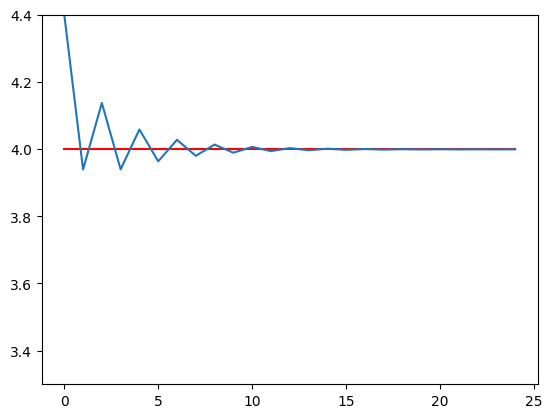

In [175]:
desired_voltages = [cs.v_desired]*len(times)

fig1=plt.gcf()

# time_sm = np.array(times) 
# time_smooth = np.linspace(time_sm.min(), time_sm.max(), 500) 
# dvsm = make_interp_spline(time_smooth,np.array(voltages))
# y = dvsm(time_smooth)
plt.plot(times,desired_voltages,'red')
plt.plot(times,voltages)
plt.ylim(3.3,4.4)
plt.show()

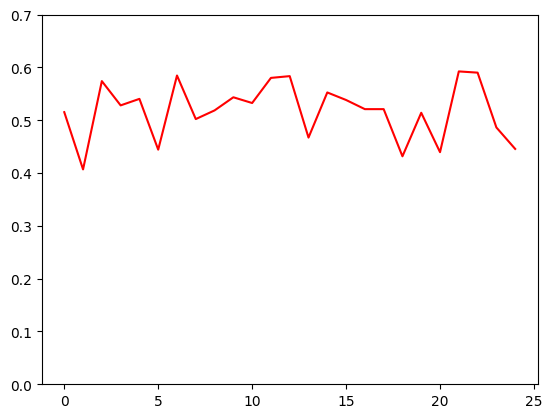

In [176]:
plt.plot(times,charging_voltages,'red')
# plt.plot(times,voltages)
plt.ylim(0,0.7)
plt.show()

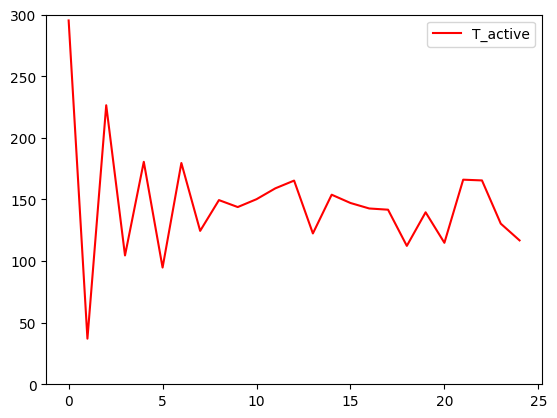

In [177]:
plt.plot(times,Tactive,'red', label='T_active')
# plt.plot(times,voltages)
plt.ylim(0,300)
plt.legend()
plt.show()


In [166]:
print(Tactive[0])

276.4163900257594
